In [515]:
import pandas as pd
import numpy as np
import re
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt


In [516]:
def extract_answer(text):
    try:
        text_processed = text.split('"answer":')[-1].split('\n')[0].strip().split('"')[1].strip()
    except:
        text_processed = text.split('"answer":')[-1].split('\n')[0].strip()
    return text_processed

def correct_paranthesis_split(text):
    try:
        text_processed = text.split('"answer":')[-1].split("\n")[1].split(":")[-1].split('"')[1].strip()
        return text_processed
    except:
        return text
    


In [553]:
PROMPT_RESPONSE_PATH = "../../../data/analysis_results/gpt_4_prompt_based_two_hop_mcq_from_monarch_response.csv"
RAG_RESPONSE_PATH = "../../../data/analysis_results/gpt_4_node_retrieval_rag_based_two_hop_mcq_from_monarch_response.csv"

# PROMPT_RESPONSE_PATH = "../../../data/analysis_results/Llama_2_13b_chat_hf_prompt_based_two_hop_mcq_from_robokop_response.csv"
# RAG_RESPONSE_PATH = "../../../data/analysis_results/Llama_2_13b_chat_hf_node_retrieval_rag_based_two_hop_mcq_from_robokop_response.csv"


In [554]:
prompt_response_df = pd.read_csv(PROMPT_RESPONSE_PATH)
rag_response_df = pd.read_csv(RAG_RESPONSE_PATH)

prompt_response_df.loc[:, 'extracted_answer'] = prompt_response_df['llm_answer'].apply(extract_answer)
rag_response_df.loc[:, 'extracted_answer'] = rag_response_df['llm_answer'].apply(extract_answer)

prompt_response_df_paranthesis_split = prompt_response_df[prompt_response_df.extracted_answer=="{"]
if prompt_response_df_paranthesis_split.shape[0] > 0:
    prompt_response_df_paranthesis_split.loc[:, "extracted_answer"] = prompt_response_df_paranthesis_split.llm_answer.apply(correct_paranthesis_split)
    prompt_response_df_wo_paranthesis_split = prompt_response_df[prompt_response_df.extracted_answer != "{"]
    prompt_response_df = pd.concat([prompt_response_df_wo_paranthesis_split, prompt_response_df_paranthesis_split])

rag_response_df_paranthesis_split = rag_response_df[rag_response_df.extracted_answer=="{"]
if rag_response_df_paranthesis_split.shape[0] > 0:
    rag_response_df_paranthesis_split.loc[:, "extracted_answer"] = rag_response_df_paranthesis_split.llm_answer.apply(correct_paranthesis_split)
    rag_response_df_wo_paranthesis_split = rag_response_df[rag_response_df.extracted_answer != "{"]
    rag_response_df = pd.concat([rag_response_df_wo_paranthesis_split, rag_response_df_paranthesis_split])

prompt_response_df = prompt_response_df[~prompt_response_df.correct_answer.str.contains("ClinVarVariant")].reset_index()
rag_response_df = rag_response_df[~rag_response_df.correct_answer.str.contains("ClinVarVariant")].reset_index()


In [547]:
rag_response_df_ = rag_response_df[rag_response_df.question.str.contains("Gene")].reset_index()
rag_response_df_
print(rag_response_df_.iloc[2].question)
print(rag_response_df_.iloc[2].extracted_answer)


Out of the given list, which Gene is associated with psoriasis and herpes zoster. Given list is: HLA-B, PCDH15, DLX6-AS1, TERT, PCSK6-AS1
The context does not provide information on which gene is associated with both psoriasis and herpes zoster.


In [564]:
prompt_response_df[prompt_response_df.correct_answer != prompt_response_df.extracted_answer]

evaluate(prompt_response_df)
# prompt_response_df[prompt_response_df.extracted_answer == "None"]

# prompt_response_df.iloc[50].question


rag_response_df[rag_response_df.extracted_answer=="None"]


rag_response_df.iloc[1].question


'Out of the given list, which Gene is associated with psoriasis and myelodysplastic syndrome. Given list is: HLA-B, ABO, UMPS, ENSEMBL:ENSG00000237844, CDK8'

In [573]:
prompt_response_df.loc[:, "total_ans"] = prompt_response_df.extracted_answer.apply(lambda x:len(x.split(",")))
prompt_response_df[prompt_response_df.total_ans > 1]


,index,question,correct_answer,llm_answer,extracted_answer,total_ans
16,16,"Out of the given list, which Gene is associate...",CASC8,"{\n ""answer"": ""CASC8, TERT""\n}","CASC8, TERT",2
75,75,"Out of the given list, which Gene is associate...",HLA-DQB1,"{\n ""answer"": ""HLA-DQB1, TERT""\n}","HLA-DQB1, TERT",2
93,93,"Out of the given list, which Gene is associate...",HLA-B,"{\n ""answer"": ""HLA-B, IL6""\n}","HLA-B, IL6",2
97,97,"Out of the given list, which Gene is associate...",HLA-B,"{\n ""answer"": ""HLA-B, HLA-DRB5""\n}","HLA-B, HLA-DRB5",2
199,199,"Out of the given list, which Gene is associate...",HLA-DQB1,"{\n ""answer"": ""HLA-DQB1, ERAP1""\n}","HLA-DQB1, ERAP1",2
266,266,"Out of the given list, which Gene is associate...",STAT4,"{\n ""answer"": ""STAT4, HLA-DQB1""\n}","STAT4, HLA-DQB1",2
269,269,"Out of the given list, which Gene is associate...",IL23R,"{\n ""answer"": ""IL23R, HLA-DPB1""\n}","IL23R, HLA-DPB1",2
357,370,"Out of the given list, which Variant is associ...",rs2736100,"{\n ""answer"": ""rs2736100, ClinVarVariant:1579...","rs2736100, ClinVarVariant:1579",2


In [572]:
rag_response_df.loc[:, "total_ans"] = rag_response_df.extracted_answer.apply(lambda x:len(x.split(",")))
rag_response_df[rag_response_df.total_ans > 1]

# rag_response_df.iloc[176].llm_answer


# rag_response_df

,index,question,correct_answer,llm_answer,extracted_answer,total_ans
0,0,"Out of the given list, which Gene is associate...",HLA-B,"{\n ""answer"": ""HLA-B, TRAF3IP2""\n}","HLA-B, TRAF3IP2",2
31,31,"Out of the given list, which Gene is associate...",HLA-DRB9,"{\n ""answer"": ""None of the genes in the given...",None of the genes in the given list are associ...,2
37,37,"Out of the given list, which Gene is associate...",MYH7,"{""answer"": ""MYH7, GTF2I""}","MYH7, GTF2I",2
87,87,"Out of the given list, which Gene is associate...",VAV3,"{""answer"": ""VAV3, MTTP""}","VAV3, MTTP",2
95,95,"Out of the given list, which Gene is associate...",HLA-B,"{\n ""answer"": ""HLA-B, HLA-DQB1""\n}","HLA-B, HLA-DQB1",2
168,168,"Out of the given list, which Gene is associate...",HLA-DQB1,"{\n ""answer"": ""HLA-DQB1, CLPTM1L""\n}","HLA-DQB1, CLPTM1L",2
205,205,"Out of the given list, which Gene is associate...",CDKN2B-AS1,"{\n ""answer"": ""LPP, OPTN""\n}","LPP, OPTN",2
248,248,"Out of the given list, which Gene is associate...",CFH,"{\n ""answer"": ""CFH, APOE""\n}","CFH, APOE",2
261,261,"Out of the given list, which Gene is associate...",ADGRV1,"{\n ""answer"": ""ADGRV1, PBX2""\n}","ADGRV1, PBX2",2
263,263,"Out of the given list, which Gene is associate...",HLA-DRB9,"{\n ""answer"": ""None of the genes in the given...",None of the genes in the given list are associ...,2


In [509]:
evaluate(prompt_response_df_sample)

(0.8, 0.2)

In [555]:
def evaluate(df):
    correct = df[df.correct_answer == df.extracted_answer]
    incorrect = df[df.correct_answer != df.extracted_answer]
    correct_frac = correct.shape[0]/df.shape[0]
    incorrect_frac = incorrect.shape[0]/df.shape[0]
    return correct_frac, incorrect_frac

niter = 100
nsample = 30

prompt_correct_frac_list = []
rag_correct_frac_list = []
for _ in tqdm(range(niter)):
    prompt_response_df_sample = prompt_response_df.sample(n=nsample)
    prompt_correct_frac, prompt_incorrect_frac = evaluate(prompt_response_df_sample)

    rag_response_df_sample = rag_response_df.iloc[prompt_response_df_sample.index]
    rag_correct_frac, rag_incorrect_frac = evaluate(rag_response_df_sample)

    prompt_correct_frac_list.append(prompt_correct_frac)
    rag_correct_frac_list.append(rag_correct_frac)


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1043.50it/s]


/var/folders/p1/h56gxdhs5vgb0ztp7h4z606h0000gn/T/ipykernel_42779/2477094116.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(prompt_correct_frac_list, color="blue", shade=True, label="Prompt based", ax=ax, lw=2, linestyle="-", alpha=0.6)
/var/folders/p1/h56gxdhs5vgb0ztp7h4z606h0000gn/T/ipykernel_42779/2477094116.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(rag_correct_frac_list, color="lightcoral", shade=True, label="KG-RAG based", ax=ax, lw=2, linestyle="-", alpha=0.6)


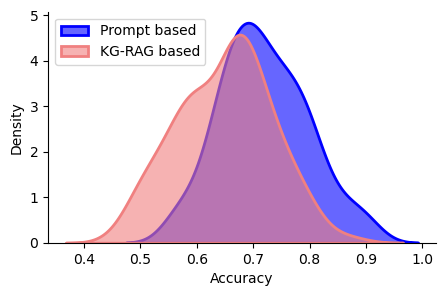

In [556]:

# Create a figure and axis
fig = plt.figure(figsize=(5, 3))
ax = plt.gca()

# Plot KDEs with the specified styling
sns.kdeplot(prompt_correct_frac_list, color="blue", shade=True, label="Prompt based", ax=ax, lw=2, linestyle="-", alpha=0.6)
sns.kdeplot(rag_correct_frac_list, color="lightcoral", shade=True, label="KG-RAG based", ax=ax, lw=2, linestyle="-", alpha=0.6)

# Set the outline color to black
for artist in ax.lines:
    artist.set_edgecolor("black")

# Add labels and legend
plt.xlabel("Accuracy")
plt.ylabel("Density")
plt.legend(loc="upper left")

sns.despine(top=True, right=True)

# Show the plot
plt.show()

# figure_folder_name = "Llama"
# fig_filename = "../../../data/analysis_results/figures/{}/two_hop_ROBOKOP_mcq_llm_performance.svg".format(figure_folder_name)
# fig.savefig(fig_filename, format='svg', bbox_inches='tight')


In [560]:
np.mean(rag_correct_frac_list)

0.6493333333333335

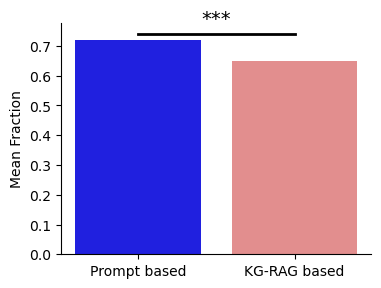

In [557]:


# Perform a t-test
t_stat, p_value = stats.ttest_ind(prompt_correct_frac_list, rag_correct_frac_list)

# Create a figure and axis
plt.figure(figsize=(4, 3))
ax = plt.gca()

# Create bar plot with error bars
sns.barplot(x=["Prompt based", "KG-RAG based"], y=[np.mean(prompt_correct_frac_list), np.mean(rag_correct_frac_list)], errorbar="sd", palette=["blue", "lightcoral"], ax=ax)

# Calculate the height for the text and line
height = max(np.mean(prompt_correct_frac_list), np.mean(rag_correct_frac_list)) + 0.02

# Add a horizontal line between the two bars
ax.plot([0, 1], [height, height], c="black", lw=2)

# Add text annotation for significance
if p_value > 0.05:
    annotation = "ns"
elif 0.001 < p_value <= 0.05:
    annotation = "*"
else:
    annotation = "***"

# Add the annotation text above the line
plt.text(0.5, height + 0.02, annotation, ha='center', va='bottom', fontsize=14)

# Add labels
plt.ylabel("Mean Fraction")

sns.despine(top=True, right=True)

# Show the plot
plt.show()


In [558]:
p_value

4.211617193563686e-09

In [256]:
len(prompt_correct_frac_list)

100